In [2]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [3]:
from coin_if import COINWrapper,read_COIN_params

In [4]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [5]:
from coin_if import read_COIN_params
raw_coin_params = read_COIN_params('/fitted_parameters/')

In [6]:
args = SimpleNamespace()
args.paradigm = ['evoked', 'spontaneous']

paradigm_short = {
    'evoked': 'E',
    'spontaneous': 'S'
}

paradigm_info = {
    'evoked': {
        'i_min': 1,
        'i_max': 8,},

    'spontaneous': {
        'i_min': 1,
        'i_max': 8,}
    }



In [7]:
data = {}
opt_data = {}
paradigm_by_id_lut = {}
id = 0
param_names = [k for k in raw_coin_params['E1'].keys()]

# 
param_remapping = {'prior_sigma_retention': {'name':'prior_precision_retention', 'fun': lambda x: 1/x**2},
                   'prior_sigma_drift': {'name':'prior_precision_drift', 'fun': lambda x: 1/x**2}}

def remap_params(params):
    for k in param_remapping.keys():
        if k in params:
            new_name = param_remapping[k]['name']
            new_value = param_remapping[k]['fun'](params[k])
            params[new_name] = new_value
            del params[k]
    return params
                   

if type(args.paradigm) is not str:
    for paradigm in args.paradigm:
        for i in range(paradigm_info[paradigm]['i_min'],paradigm_info[paradigm]['i_max']+1):
            # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
            # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
            
            # with open(f'{ROOT_PATH}/experimental/coin_{paradigm}_run012_MSE_{i}.pkl','rb') as f:
            #     opt_data[id] = pickle.load(f)
            kk = paradigm_short[paradigm]+str(i)
            #opt_data[id] = {'MSE':{'x':[raw_coin_params[kk][p] for p in param_names]}}
            opt_data[id] = {'MSE':{'x':[]}}
            for p in param_names:
                _val = raw_coin_params[kk][p]
                if p in param_remapping.keys():
                    _val = param_remapping[p]['fun'](_val)
                opt_data[id]['MSE']['x'].append(_val)
            
            paradigm_by_id_lut[id] = paradigm

            df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{paradigm}_recovery_participant{i}.csv')
            y = df.Adaptation.to_numpy()
            y *= np.sign(np.nansum(y))
            data[id] = y

            id += 1

#remapping param_names
new_param_names = []
for k in param_names:
    if k in param_remapping.keys():
        new_param_names.append(param_remapping[k]['name'])
    else:
        new_param_names.append(k)
param_names = new_param_names

In [8]:
param_names

['sigma_process_noise',
 'prior_mean_retention',
 'prior_precision_retention',
 'prior_precision_drift',
 'alpha_context',
 'rho_context',
 'sigma_motor_noise',
 'alpha_cue']

In [9]:
opt_data

{0: {'MSE': {'x': [0.1234,
    0.8827,
    3086.4197530864203,
    17313.019390581718,
    120.0,
    0.2699,
    0.0901,
    nan]}},
 1: {'MSE': {'x': [0.1441,
    0.9121,
    11111111.111111114,
    13211.784912141633,
    380.0,
    0.1285,
    0.0804,
    nan]}},
 2: {'MSE': {'x': [0.1119,
    0.9466,
    277777777.77777773,
    17777.777777777777,
    230.0,
    0.007,
    0.0781,
    nan]}},
 3: {'MSE': {'x': [0.1172,
    0.8578,
    6944.444444444444,
    28727.37719046251,
    12.0,
    0.0477,
    0.0883,
    nan]}},
 4: {'MSE': {'x': [0.0705,
    0.946,
    591715.976331361,
    38446.75124951941,
    10000000.0,
    0.3911,
    0.0715,
    nan]}},
 5: {'MSE': {'x': [0.0559,
    0.9643,
    111111.11111111111,
    41649.312786339025,
    29.0,
    0.0044,
    0.0966,
    nan]}},
 6: {'MSE': {'x': [0.0926,
    0.9422,
    3906250000.0,
    91827.36455463729,
    3700000.0,
    0.0003,
    0.0936,
    nan]}},
 7: {'MSE': {'x': [0.099,
    0.8405,
    189035.91682419658,
    198

In [10]:
def scale_and_bias(x,bias=0,scale=1.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict()        

fixed_params['runner'] = {
    "runner_method_alias": "blackbox",  
    "model_type": "coin",               # Distinguish from 'torch' or 'numpy'
    "do_backprop": False,               # No training/backpropagation for COIN
    "load_model_at_init": False,        # COIN doesn’t support state_dict saving/loading
    "save_model_at_init": False,        # Ensure no torch parameter saving is attempted
    'initial_state': [], 
    "tau_u": 1,                        # Can be set if needed (may be unused in COIN mode)
}



optim_param_mapping= [('model', param_name) for param_name in param_names] 
            
custom_param_mappings = []

wrapped_runner = wrap_runner_for_optimization(model_class = COINWrapper,
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [11]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 120),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

# data = {}
# id = 0
# for , paradigm in paradigm_by_id_lut.items():
    
# stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [12]:
pooling_fun = 'MSE'

In [13]:
outs  = {k: wrapped_runner(stimuli[paradigm_by_id_lut[k]],opt_data[k][pooling_fun]['x']) for k in opt_data}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]/homes/ar2342/frogs_project/COIN_Python/coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
/homes/ar2342/frogs_project/COIN_Python/utils/general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
/homes/ar2342/frogs_project/COIN_Python/coin.py:725: RuntimeWarning: invalid value encountered in sqrt
  coin_state["previous_x_dynamics"] = m + np.sqrt(v) * np.random.randn(self.max_contexts+1, self.particles)
/homes/ar2342/frogs_project/COIN_Python/coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.19s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.12s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.43s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.25s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.55s/it]


Text(0.5, 1.0, 'subjects -->>1')

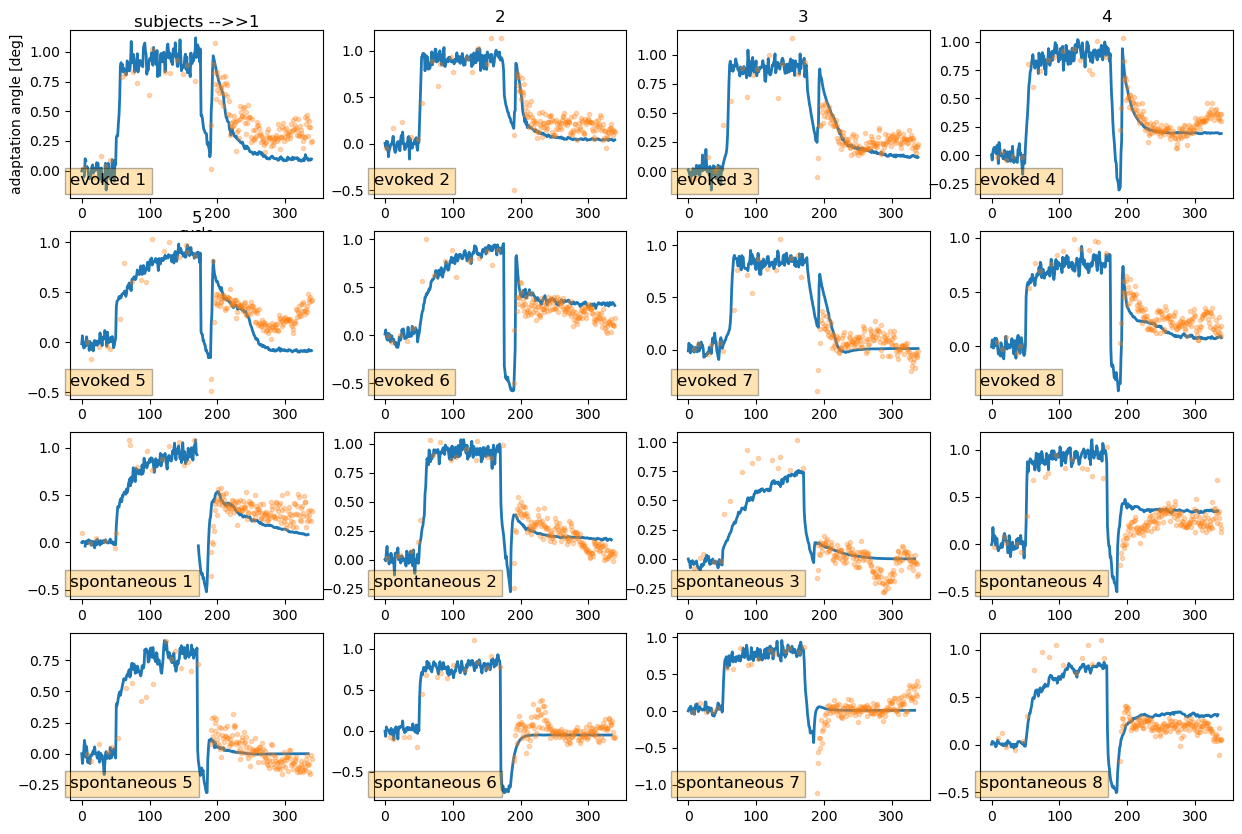

In [14]:
plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(4,4,k+1)
    ydata_model = outs[k]
    xdata_model = np.arange(1,len(ydata_model)+1)
    ydata_experiment = data[k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model)]
    ydata_model = ydata_model[~np.isnan(ydata_model)]
    xdata_experiment = xdata_experiment[~np.isnan(ydata_experiment)]
    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]
    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
                 bbox=dict(facecolor='orange', alpha=0.3))



plt.subplot(4,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)



# plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [15]:
outs_ = [o for _,o in outs.items()]
outs_ = np.array(outs_)
data_ = np.array([data[k] for k in opt_data])

/tmp/ipykernel_3871993/546502521.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  outs_ = np.array(outs_)


In [16]:
nana_break

NameError: name 'nana_break' is not defined

In [ ]:
A_times = [0,5,10,20] 
antero_short   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Simulting the COIN model


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


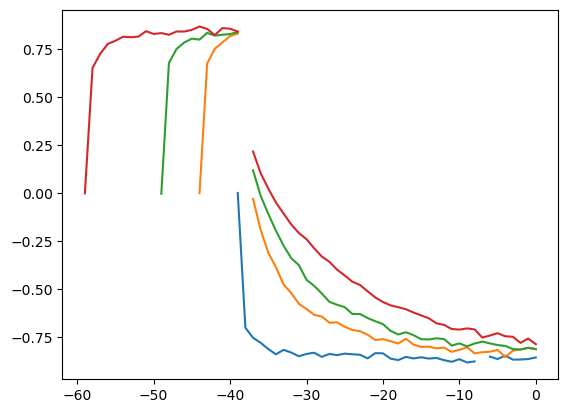

In [ ]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.12s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.78s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.67s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.36s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.58s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.33s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.75s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:11<00:00, 11.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:09<00:00,  9.68s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.83s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.78s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:11<00:00, 11.28s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.33s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:14<00:00, 14.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.20s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.08s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.19s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:11<00:00, 11.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:11<00:00, 11.21s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.12s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:20<00:00, 20.82s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.31s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.51s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.44s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:18<00:00, 18.95s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.33s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.25s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:18<00:00, 18.27s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.85s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:18<00:00, 18.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.02s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.35s/it]


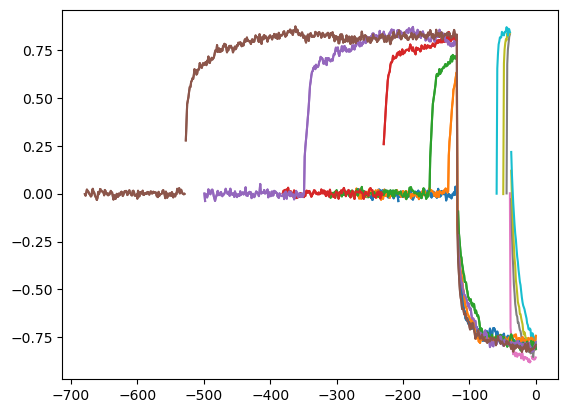

In [ ]:
TaN=150
TaB=120

ref_antero_playlist = {'AB0':[(P0, TaN),(Pminus, TaB)],
'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
'AB4':[(P0, TaN),(Pplus,230),(Pminus, TaB)],
'AB5':[(P0, TaN),(Pplus,410),(Pminus, TaB)]}

antero   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in ref_antero_playlist.items()}
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
for aa,A_time in enumerate(A_times):
    y = np.mean(antero_short[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
# frog_ens = [True,False]
# Tfrog = 400
# frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}
# for frog_en in frog_ens:
#     plt.plot(np.mean(frogs[frog_en],axis=0))
# from siggen_utils import herzfeld_block


# def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
#     out_dict = {}
#     for z in z_list:
#         scenario_name =  f'herzfeld,z={z}'
#         pert_per_z = []
#         for n in range(n_blocks):
#             hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
#             pert_per_z.append((hz,len(hz)))
#         out_dict.update({scenario_name:pert_per_z})
#     return out_dict

# hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
# hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
# # her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}
# her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}
# for iz, z in enumerate(hrz_params['z_list']):
#     deltas = []
#     mm = lambda x: np.mean(x,axis=0)
#     scenario = f'herzfeld,z={z}'
#     this_result = her_results[scenario]
#     pointer = 0
#     for bb in range(hrz_params['n_blocks']):
#         block_length = hrz_playlist[scenario][bb][-1]
#         pointer += block_length
#         deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

#     plt.plot(deltas,'x',label = f'z={z}')


# # for frog_en in frog_ens:
# #     plt.plot(np.mean(frogs[frog_en],axis=0))

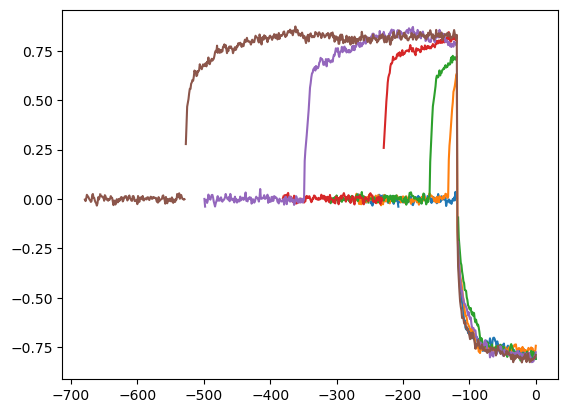

In [ ]:
for aa,aa_item in ref_antero_playlist.items():
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)

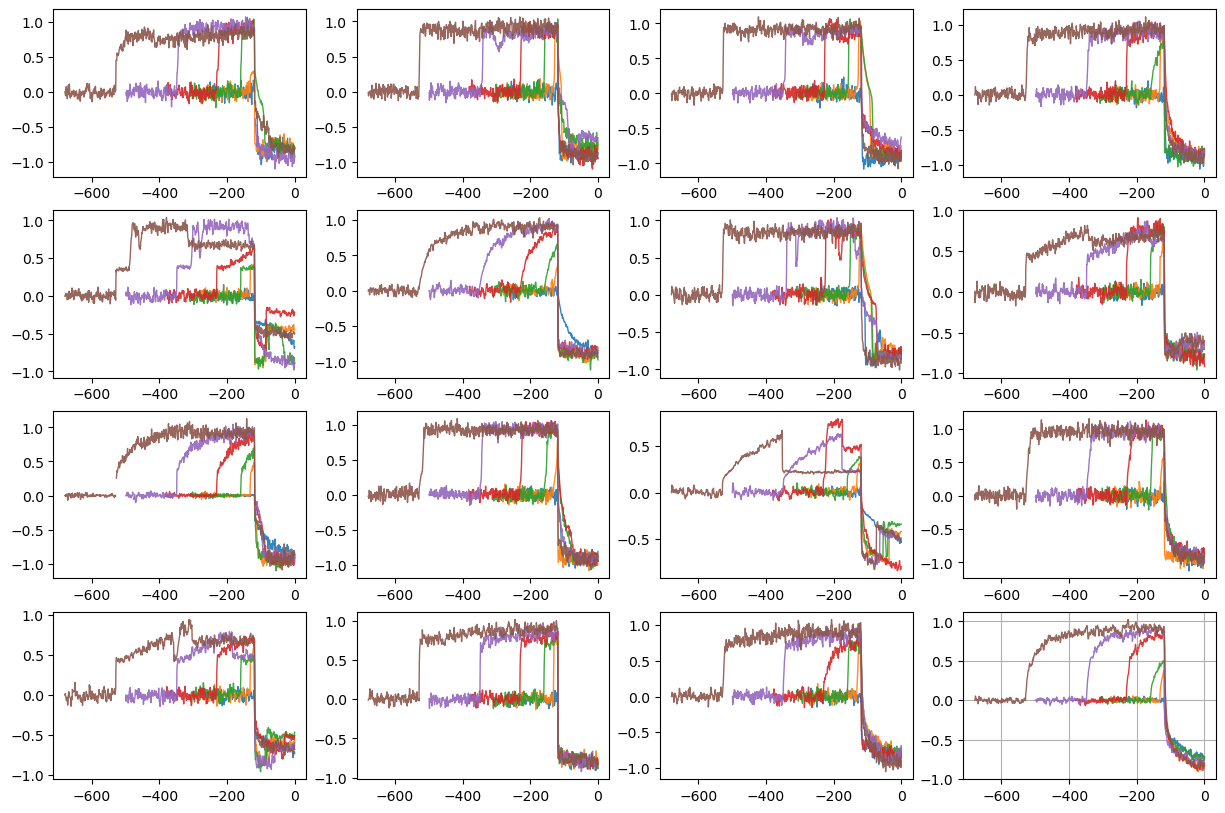

In [ ]:
plt.figure(figsize=(15,10))
for ii in range(16):
    for aa,aa_item in antero.items():
        plt.subplot(4,4,ii+1)
        y = antero[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

In [ ]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.45s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.90s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:10<00:00, 10.39s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.47s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.48s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.99s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.08s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.40s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.36s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.42s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.35s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.15s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:08<00:00,  8.60s/it]


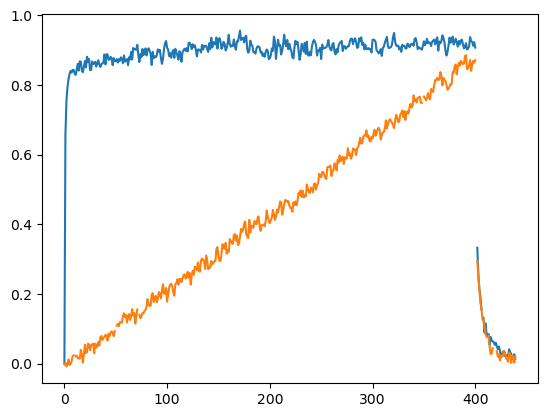

In [ ]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [ ]:
from siggen_utils import herzfeld_block


def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
    out_dict = {}
    for z in z_list:
        scenario_name =  f'herzfeld,z={z}'
        pert_per_z = []
        for n in range(n_blocks):
            hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
            pert_per_z.append((hz,len(hz)))
        out_dict.update({scenario_name:pert_per_z})
    return out_dict

hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
hrz_playlist =  generate_herzfeld_scenarios(**hrz_params)
her_results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in hrz_playlist.items()}

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:38<00:00, 38.64s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.65s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:35<00:00, 35.93s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.09s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:56<00:00, 56.35s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:49<00:00, 49.18s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:41<00:00, 42.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:50<00:00, 50.41s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:49<00:00, 49.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:34<00:00, 34.71s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:54<00:00, 54.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 47.22s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:51<00:00, 51.11s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:42<00:00, 42.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 48.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:38<00:00, 38.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:45<00:00, 45.52s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.08s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:53<00:00, 53.24s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:49<00:00, 49.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.74s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 47.17s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:42<00:00, 42.81s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.97s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:50<00:00, 50.90s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:50<00:00, 50.78s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:57<00:00, 57.86s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:37<00:00, 37.78s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:41<00:00, 41.66s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 47.36s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:44<00:00, 45.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.22s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:43<00:00, 43.88s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.87s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:51<00:00, 51.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 47.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:44<00:00, 44.99s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:43<00:00, 43.19s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:40<00:00, 40.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:47<00:00, 47.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:53<00:00, 53.80s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:39<00:00, 39.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:58<00:00, 58.93s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.17s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:43<00:00, 43.20s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:45<00:00, 45.85s/it]


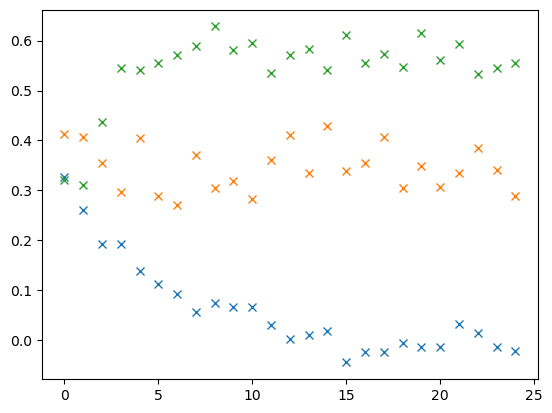

In [ ]:
for iz, z in enumerate(hrz_params['z_list']):
    deltas = []
    mm = lambda x: np.mean(x,axis=0)
    scenario = f'herzfeld,z={z}'
    this_result = her_results[scenario]
    pointer = 0
    for bb in range(hrz_params['n_blocks']):
        block_length = hrz_playlist[scenario][bb][-1]
        pointer += block_length
        deltas.append(mm(her_results[scenario])[pointer-1]-mm(her_results[scenario])[pointer-3])            

    plt.plot(deltas,'x',label = f'z={z}')

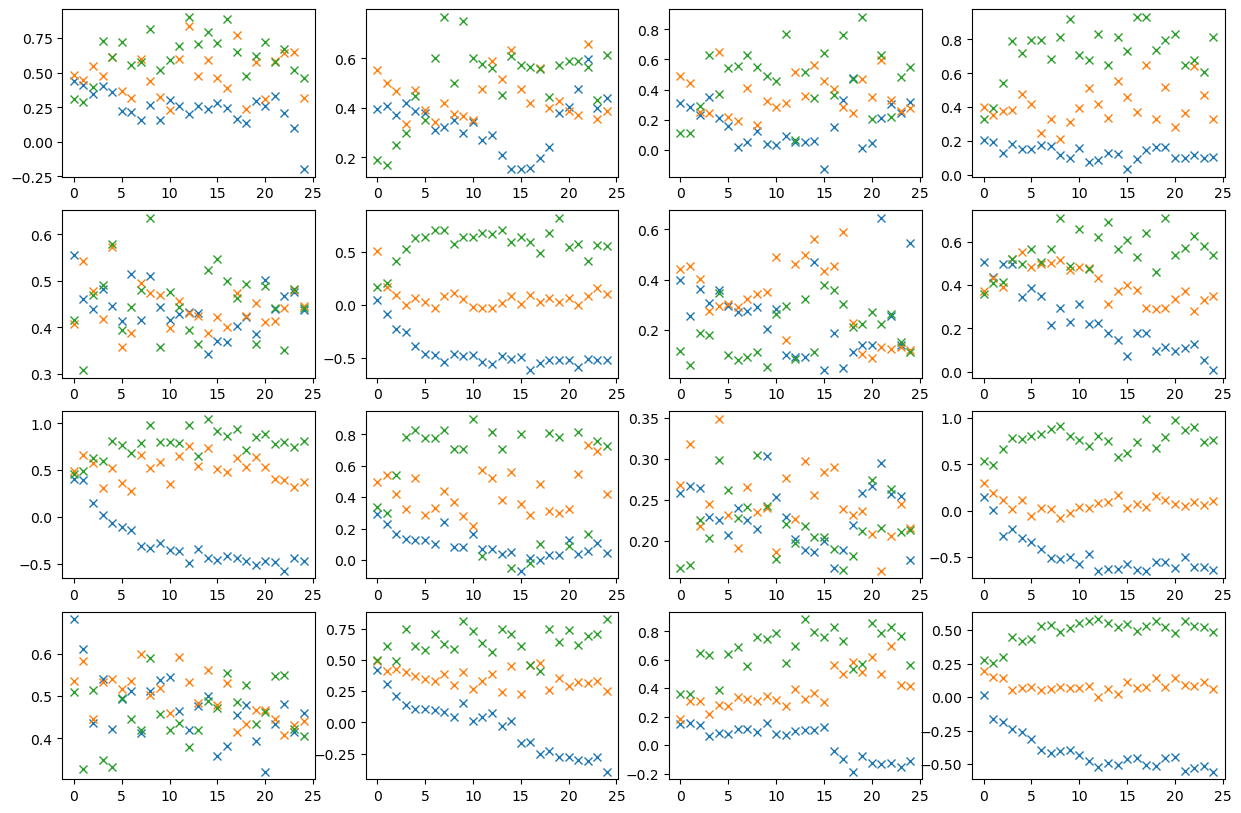

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
plt.figure(figsize=(15,10))
for iz, z in enumerate(hrz_params['z_list']):
    for ii in range(16):
        plt.subplot(4,4,ii+1)
        deltas = []
        mm = lambda x: np.mean(x,axis=0)
        scenario = f'herzfeld,z={z}'
        this_result = her_results[scenario]
        pointer = 0
        for bb in range(hrz_params['n_blocks']):
            block_length = hrz_playlist[scenario][bb][-1]
            pointer += block_length
            deltas.append((her_results[scenario])[ii][pointer-1]-(her_results[scenario])[ii][pointer-3])            

        plt.plot(deltas,'x',label = f'z={z}')

NameError: name 'plt' is not defined

In [ ]:
np.shape(her_results[scenario][0][pointer-1])

()

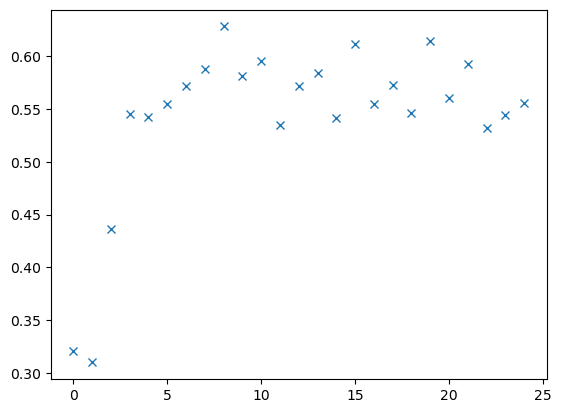

In [ ]:
plt.plot(deltas,'x',label = f'z={z}')

In [ ]:
playlist = {'Ac':[(P0, 200),(Pplus, 200),(Pchannel,200)],
            'ABc':[(P0, 200),(Pplus, 200),(Pminus, 200),(Pchannel,200)]}

results   = {aa: [ wrapped_runner(aa_item,opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,aa_item in playlist.items()}


Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.93s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.50s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.77s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.53s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.68s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:14<00:00, 14.97s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.59s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.47s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.57s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:16<00:00, 16.86s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:12<00:00, 12.28s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:17<00:00, 17.14s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:29<00:00, 29.80s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:24<00:00, 24.60s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.89s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:22<00:00, 22.73s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:27<00:00, 27.00s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:36<00:00, 36.24s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.76s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.87s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.69s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:21<00:00, 21.54s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:26<00:00, 26.38s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.34s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.63s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:19<00:00, 19.79s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:23<00:00, 23.72s/it]


Simulting the COIN model


100%|██████████| 1/1 [00:25<00:00, 25.17s/it]


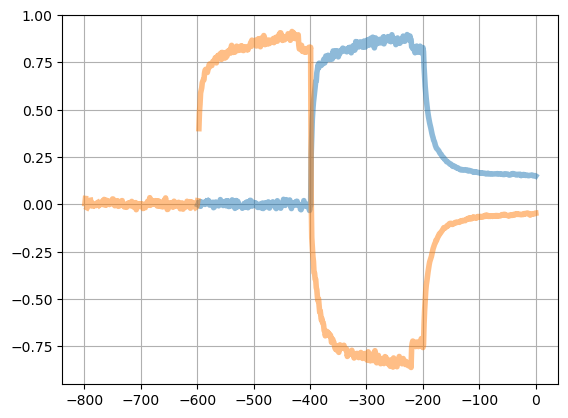

In [ ]:
for aa,aa_item in results.items():
    y = np.mean(results[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y, linewidth=4, alpha=0.5)
plt.grid()

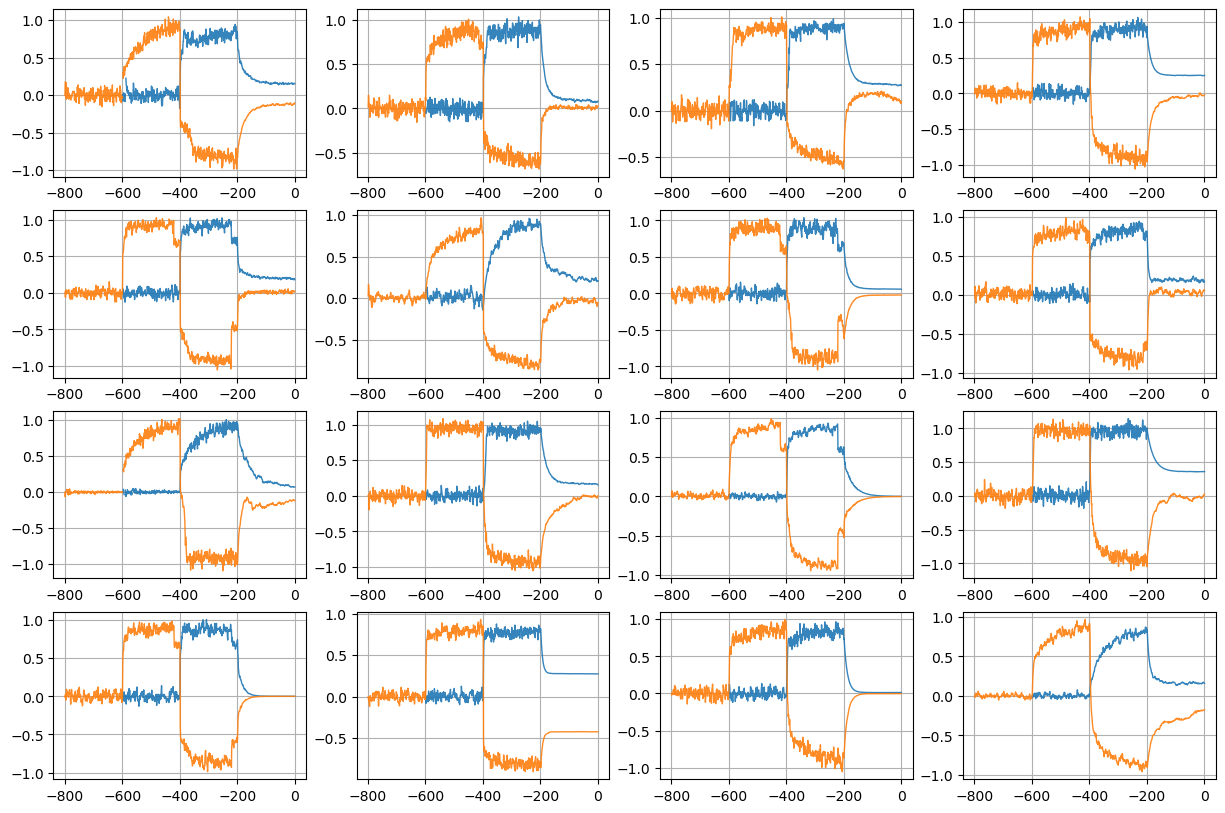

In [ ]:
plt.figure(figsize=(15,10))
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
    plt.grid()

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()

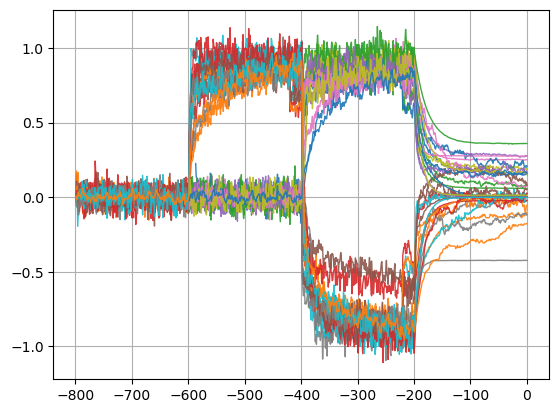

In [ ]:
for ii in range(16):
    for aa,aa_item in results.items():
        # plt.subplot(4,4,ii+1)
        y = results[aa][ii]
        x = np.arange(len(y))
        x = x - x[-1]
        plt.plot(x,y, linewidth=1, alpha=0.9)
plt.grid()